In [20]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt
%matplotlib inline

# Functions/Methods

In [21]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        statistic = model[0]
        
        # Dickey-Fuller
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        
        # Augmented Dickey Fuller (ADF)
        if (abs(statistic) > abs(model[4]['1%'])):
            self.perc_stat = 99
        elif (abs(statistic) > abs(model[4]['5%'])):
            self.perc_stat = 95
        elif (abs(statistic) > abs(model[4]['10%'])):
            self.perc_stat = 90
    
        return self.is_stationary

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0, period=250):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue

            # filter by period
            y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
            
            model = model_ols(y, x)
            adf.check(model.resid)
            beta = model.params[1]
            
            # check is stationary
            if (adf.is_stationary):
                rows.append([len(x), y_symbol, x_symbol, adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Period', 'Dependente', 'Independente', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des
        
def analysis_by_periods(y, x):
    rows=[]
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        # filter by period
        y_values, x_values = getvalues_by_period(y, x, period)

        coin = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)
            
        rows.append([period, coin[0], coin[1], coin[2], coin[3], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

def return_varlog(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = np.log(time_series/lag)
    ret[0] = 0
    return ret

def cointegration(y, x, period = 250):
    adf = DickeyFuller()
    if (period == 0):
        period = len(y)

    y, x = getvalues_by_period(y, x, period)
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

def apply_halflife(data, pairs, period = 250):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs, period=250):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x, inlog=False):
    if inlog:
        y = return_varlog(y)
        x = return_varlog(x)
    
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs, period=250):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Short/Long'
        zcurrent = zscore_up
    else:
        desc = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs, period=250):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]

def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary]

def getvalues_by_period(y, x, period):
    if(period <= 0):
        return y, x
    
    n = len(y)
    if(period < n):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    return y, x

def zscore(series):
    return (series - series.mean()) / np.std(series)

def show(data, y_symbol, x_symbol, period=250):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    #plt.figure(figsize=(10,5))
    #plt.plot(model.resid)
    model.resid.plot(figsize=(12,6))
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [22]:
path_data_cart = 'datasets/data_cart.csv'
path_data_full = 'datasets/data.csv'
path_data_alpha = 'datasets/data_alpha.csv'

In [23]:
df = pd.read_csv(path_data_cart, index_col=0)
data = df[df.columns.difference(['Data', 'Date'])]
data.shape, 'from {} to {}'.format(data.index[0], data.index[-1])

((300, 71), 'from 03/04/2019 to 17/06/2020')

In [24]:
pairs = find_cointegrated_pairs(data)
pairs.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta
0,250,ABEV3,BBDC3,0.030444,95,0.439490
1,250,ABEV3,BBDC4,0.019251,95,0.409269
2,250,ABEV3,BBSE3,0.042483,95,0.602585
3,250,ABEV3,BRFS3,0.015478,95,0.359280
4,250,ABEV3,CIEL3,0.029676,95,1.765738


In [25]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Half-Life applied successfully


In [26]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [27]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [28]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [29]:
pairs.head(3)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.030444,95,0.439490,12,0.406583,0.933439,0.227480,Short/Long
1,250,ABEV3,BBDC4,0.019251,95,0.409269,11,0.392101,0.933728,0.225792,Short/Long
2,250,ABEV3,BBSE3,0.042483,95,0.602585,11,0.297218,0.897310,0.021605,Long/Short


In [30]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Analysis

In [31]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(285, 11)

In [32]:
oper = pairs;#pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
oper

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.030444,95,0.439490,12,0.406583,0.933439,0.227480,Short/Long
1,250,ABEV3,BBDC4,0.019251,95,0.409269,11,0.392101,0.933728,0.225792,Short/Long
2,250,ABEV3,BBSE3,0.042483,95,0.602585,11,0.297218,0.897310,0.021605,Long/Short
3,250,ABEV3,BRFS3,0.015478,95,0.359280,9,0.387155,0.936971,0.017625,Long/Short
4,250,ABEV3,CIEL3,0.029676,95,1.765738,7,0.346775,0.925156,0.111378,Long/Short
...,...,...,...,...,...,...,...,...,...,...,...
280,250,TAEE11,USIM5,0.026353,95,0.626118,9,0.346905,0.719506,0.357862,Short/Long
281,250,TAEE11,VIVT4,0.027825,95,0.314819,9,0.409959,0.767760,0.680749,Short/Long
282,250,TOTS3,VIVT4,0.001022,99,3.506898,6,0.267009,0.811774,1.029561,Long/Short
283,250,UGPA3,VIVT4,0.009392,95,0.789958,12,0.346738,0.770665,0.345269,Short/Long


In [33]:
#oper = oper.loc[(oper['Corr'] >= 0.70)]
#oper

#### Pares sinalizando entrada

In [42]:
signal = oper.loc[(oper['Signal'] >= 0.95)].copy()
signal.reset_index(drop=True, inplace=True)
apply_periods(data, signal)
signal.shape

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(14, 13)

In [43]:
# somente pares cointegrados em no mínimo 3 períodos
signal = signal.loc[(signal['PeriodQt'] > 2)].sort_values(by=['HalfLife'], ascending=True).copy()
signal.reset_index(drop=True, inplace=True)
signal
#signal.to_csv('datasets/cart_oper_15062020.csv', index=False)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,BRML3,LREN3,0.019232,95,0.414709,5,0.280437,0.968920,1.049719,Long/Short,6,"160,180,200,220,240,250"
1,250,TOTS3,VIVT4,0.001022,99,3.506898,6,0.267009,0.811774,1.029561,Long/Short,6,"160,180,200,220,240,250"
2,250,CYRE3,MULT3,0.006586,99,1.234043,7,0.312643,0.959217,1.264700,Short/Long,8,"120,140,160,180,200,220,240,250"
3,250,FLRY3,SULA11,0.013304,95,0.400837,7,0.392632,0.938756,1.241463,Short/Long,4,"200,220,240,250"
4,250,B3SA3,BPAC11,0.031752,95,0.278999,8,0.344769,0.817099,1.056380,Short/Long,5,"100,200,220,240,250"
5,250,HYPE3,TOTS3,0.019140,95,0.123301,8,0.268154,0.668587,1.103672,Short/Long,5,"180,200,220,240,250"
6,250,IGTA3,MRVE3,0.027915,95,2.638460,9,0.274895,0.910931,0.959426,Long/Short,3,"220,240,250"
7,250,ENGI11,MULT3,0.025849,95,0.949960,10,0.394000,0.865906,1.023329,Short/Long,6,"100,120,200,220,240,250"
8,250,LREN3,SBSP3,0.024032,95,0.853887,10,0.197286,0.894042,1.331757,Long/Short,6,"100,160,180,220,240,250"
9,250,CYRE3,SBSP3,0.007255,99,0.732853,11,0.237777,0.919233,1.033212,Long/Short,5,"180,200,220,240,250"


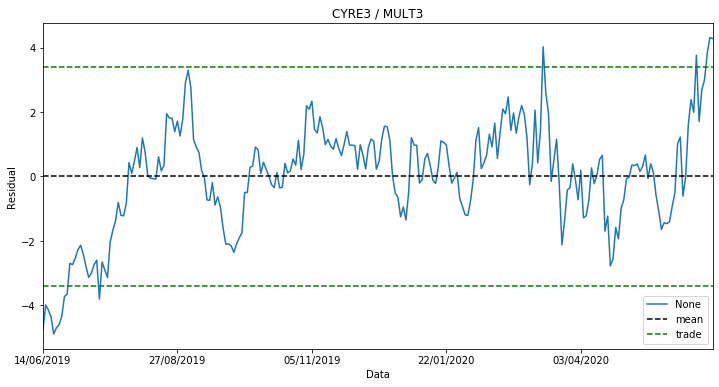

In [45]:
show(data, 'CYRE3', 'MULT3')

In [46]:
"""for i, j in signal.iterrows():
    show(data, j['Dependente'], j['Independente'])"""

"for i, j in signal.iterrows():\n    show(data, j['Dependente'], j['Independente'])"

In [38]:
analysis_by_periods(data['MULT3'], data['SBSP3'])

,Period,Stationary,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr
0,100,False,0.130120,NaN,0.524851,11,0.124190,0.896152
1,120,False,0.180798,NaN,0.568520,16,0.178831,0.902665
2,140,False,0.125517,NaN,0.568217,15,0.236300,0.906106
3,160,False,0.109412,NaN,0.569355,15,0.236631,0.902465
4,180,False,0.077775,90.0,0.559898,16,0.222252,0.888823
5,200,False,0.079265,90.0,0.558293,18,0.256951,0.886088
6,220,True,0.045869,95.0,0.553163,17,0.252843,0.882584
7,240,True,0.034366,95.0,0.547966,16,0.257867,0.875453
8,250,False,0.061671,90.0,0.536280,17,0.256574,0.865394
